In [1]:
# see test file test_burgers_white_noise_vs_pypde.sh
# (which has not been written yet)
# this file runs the second part of the test, runs PyPDE and compares the results

In [1]:
import numpy as np
import sys
import os
from glob import glob
from json import load as json_load
from numpy.fft import fft,ifft,fftfreq,fftshift
from numpy import sin,cos,exp,log,sqrt,pi

## Matplotlib Parameters

In [2]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
colors = plt.cm.Blues(np.linspace(0,1,10))
colors = plt.cm.viridis(np.linspace(1,0,10))

In [4]:
#rcParams['lines.linewidth'] = 2
#rcParams['lines.linestyle'] = '--'
rcParams['axes.titlesize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'
#rcParams['font.family'] = "sans-serif"
#rcParams['font.family'] = ["Helvetica"]
#rcParams['font.sans-serif'] = ['Helvetica']

In [5]:
from matplotlib.ticker import FuncFormatter

def format_basis10(x):
    return np.sign(x)*10**(-np.floor(np.log10(abs(x)))+np.log10(abs(x)))

def format_exp10(x):
    return np.floor(np.log10(abs(x)))

def MyFormatter(x,lim):
    if x == 0:
        return f'$0$'
    return f'${format_basis10(x):.1f} \\times 10^{{{format_exp10(x):.0f}}}$'
    #The first argument of the format gives the first significant digits of the number with the sign preserved and brought to a range between [1-10), The next argument gives the  numbers integer exponent of 10
    #Both the first and second arguments are formatted to display only 2 decimal places due to the lack of space.
    
majorFormatter = FuncFormatter(MyFormatter)

## Import data from simulations

In [6]:
# parent directory
path = os.path.abspath(os.path.join(os.path.abspath(''), os.pardir))
sys.path.append(path+'/scripts')

In [7]:
from _functions import *

In [8]:
# this is a hard coded file because the test has these fixed parameters as well

file_suffix = 'R_09000_N_008_Ltotal_001.0_L_003_sqeps_1.000000_nu_002_T_1.0e+00_NT_000'
with open(path+'/data/params_'+file_suffix+'.json','r') as file:
    json_data = json_load(file)

In [9]:
R = int(json_data['R']/1000)
BN = json_data['BN']
Lrelative = json_data['Lrelative']
Ttotal = json_data['Ttotal']
N = json_data['N']
nu = json_data['nu']
Ltotal = json_data['Ltotal']
sqeps = json_data['sqeps']
dx = json_data['dx']
NT = json_data['NT']
NTsave = json_data['NTsave']
viscte = json_data['viscte']
sqdx = json_data['sqdx']
nlinear = json_data['nlinear']
fkernel = json_data['fkernel']
initial_value = json_data['initial_value']
scheme = json_data['scheme']

# Plot Velocity Field Profiles

In [10]:
vspace = np.load(path+'/data/burgers_'+file_suffix+'.npz')['u']

In [11]:
X = fftshift( fftfreq(N) * Ltotal )

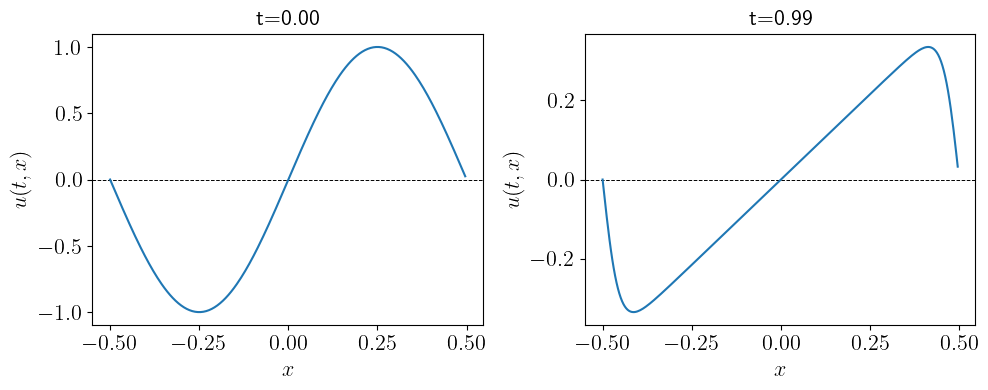

In [12]:
# initial profile of velocity field
fig, ax = plt.subplots(1,2, figsize=(10,4))

t_slice = 0
ax[0].set_title(f"t={t_slice/NTsave*Ttotal:.2f}")
ax[0].set_ylabel("$u(t,x)$")
ax[0].set_xlabel("$x$")
ax[0].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[0].plot(X,np.real(np.fft.fftshift(vspace[0,:])),label='real part')
#ax[0].yaxis.set_major_formatter(majorFormatter)
#ax[0].plot(np.imag(np.fft.fftshift(vspace[0,:])),label='imag part')
#ax[0].legend()

t_slice = NTsave-1
# final profile of velocity field
ax[1].set_title(f"t={t_slice/NTsave*Ttotal:.2f}")
ax[1].set_ylabel("$u(t,x)$")
ax[1].set_xlabel("$x$")
ax[1].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[1].plot(X,np.real(np.fft.fftshift(vspace[t_slice,:])))
#ax[1].yaxis.set_major_formatter(majorFormatter)
#ax[1].plot(np.imag(np.fft.fftshift(vspace[900,:])))

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

# With Py PDE

In [13]:
from pde import CartesianGrid,ScalarField,PDE,MemoryStorage,PDE
#from pde import PDEBase
#from pde.pdes.base import expr_prod
#from pde.tools.docstrings import fill_in_docstring
#from pde.grids.boundaries.axes import BoundariesData
#from typing import Callable

/opt/anaconda3/lib/python3.9/site-packages/pde/tools/config.py:223: UserWarning: `numpy` version 1.22.0 required for py-pde (installed: 1.21.6)
  warnings.warn(f"{msg} (installed: {version})")


In [14]:
#import numba as nb
#from numba import jit

In [15]:
# warning: only works for Ltotal = 1., don't know how to input Ltotal in definition of state
# maybe using expr_prod? but then how do I get the sine of that?
# I believe I found it!
assert np.abs(Ltotal-1.0) < 10.*np.finfo(float).eps, f"Ltotal must be 1.0, got: {Ltotal}"
grid = CartesianGrid([[-0.5*Ltotal,0.5*Ltotal]], [N], periodic=True) # generate grid
#state = ScalarField.from_expression(grid, "sin(2*pi*x/Ltotal)")
#state = ScalarField.from_expression(grid, "sin(2*pi*x)")
state = ScalarField.from_expression(grid, f"sin(2*pi*x/{Ltotal:g})")

In [16]:
storage = MemoryStorage()

trackers = [
    "progress",  # show progress bar during simulation
    #"steady_state",  # abort when steady state is reached
    storage.tracker(interval=Ttotal/NTsave)  # store data every simulation time unit
    #pde.PlotTracker(show=True),  # show images during simulation
    # print some output every 5 real seconds:
    #pde.PrintTracker(interval=pde.RealtimeInterrupts(duration=5)),
]

In [36]:
# my attempt at implementing the class, but the problem was much simpler
# I simply had to choose dt, and an explicit solver would be chosen

# code based on the KPZInterfacePDE class
# https://github.com/zwicker-group/py-pde/blob/6d6c1cc87edbd4950d1e14164b7d4bf7138dfe13/pde/pdes/kpz_interface.py
class BurgersPDE(PDEBase):
    r"""The Burgers (KPZ) equation
    The mathematical definition is
    .. math::
        \partial_t u = \nu \nabla^2 u - \lambda u * d_dx u + \eta(\boldsymbol r, t)
    where :math:`u` is the value of velocity. The
    dynamics are governed by the two parameters :math:`\nu` and :math:`\lambda`, while
    :math:`\eta` is Gaussian white noise, whose strength is controlled by the `noise`
    argument.
    """

    explicit_time_dependence = False

    @fill_in_docstring
    def __init__(
        self,
        nu: float = 0.5,
        lmbda: float = 1,
        *,
        noise: float = 0,
        bc: BoundariesData = "auto_periodic_neumann",
    ):
        r"""
        Args:
            nu (float):
                Parameter :math:`\nu` for the strength of the diffusive term
            lmbda (float):
                Parameter :math:`\lambda` for the strenth of the gradient term
            noise (float):
                Variance of the (additive) noise term
            bc:
                The boundary conditions applied to the field.
                {ARG_BOUNDARIES}
        """
        super().__init__(noise=noise)

        self.nu = nu
        self.lmbda = lmbda
        self.bc = bc

    @property
    def expression(self) -> str:
        """str: the expression of the right hand side of this PDE"""
        #return expr_prod(self.nu, "∇²c") + " - " + expr_prod(self.lmbda, "c*∇c")
        return expr_prod(self.nu, "∇²c") + " - " + "c*d_dx(c)"

    def evolution_rate(  # type: ignore
        self,
        state: ScalarField,
        t: float = 0,
    ) -> ScalarField:
        """evaluate the right hand side of the PDE
        Args:
            state (:class:`~pde.fields.ScalarField`):
                The scalar field describing the concentration distribution
            t (float): The current time point
        Returns:
            :class:`~pde.fields.ScalarField`:
            Scalar field describing the evolution rate of the PDE
        """
        assert isinstance(state, ScalarField), "`state` must be ScalarField"
        result  = self.nu * state.laplace(bc=self.bc, args={"t": t})
        result -= self.lmbda * state * state.gradient(bc=self.bc, args={"t": t}).to_scalar()
        result.label = "evolution rate"
        return result  # type: ignore

In [17]:
eq = PDE(
    {'u': '-u * d_dx(u) + nu * laplace(u)'},
    noise=sqeps**2,
    consts={'nu':nu}
    )

In [39]:
eq = BurgersPDE(nu=nu,noise=1.)  # define the SDE

  0%|          | 0/1.0 [00:00<?, ?it/s]

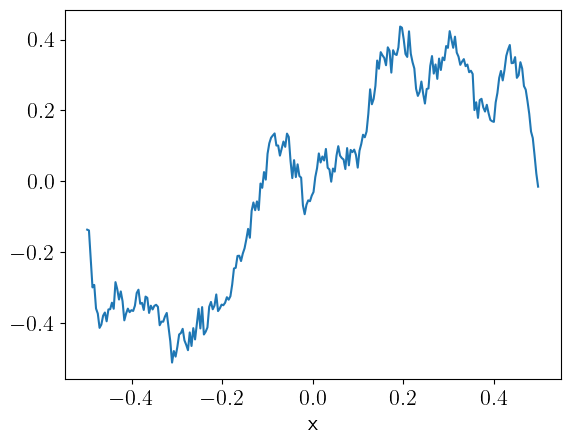

In [18]:
result = eq.solve(state, t_range=Ttotal, tracker=trackers, dt=0.1*dx) # solve the pde
result.plot()                                              # plot the resulting field

In [19]:
XPDE = -0.5*Ltotal + (np.arange(N)+.5)*dx

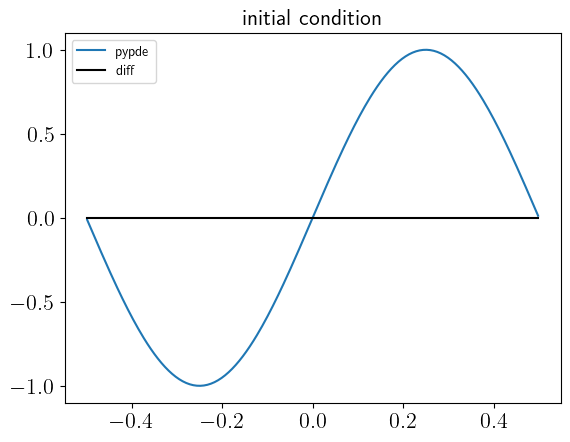

In [20]:
# initial state
plt.title( 'initial condition' )
plt.plot( XPDE, storage[0].data, label='pypde' )
plt.plot( XPDE, np.sin(2.*np.pi*XPDE)-storage[0].data, color='k', label='diff' )
plt.legend()
plt.show()

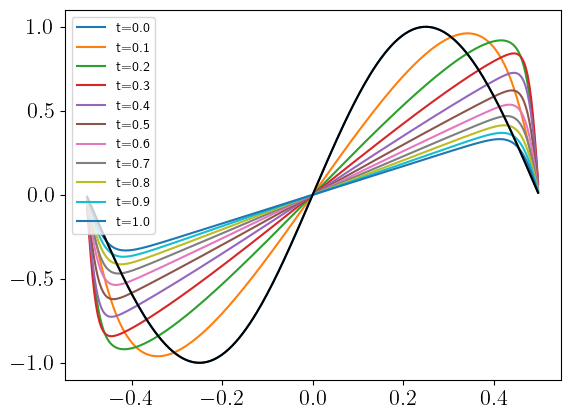

In [21]:
for i,field in enumerate(storage):
    if i%10==0:
    #if i==1000:
        plt.plot(XPDE, field.data, label=f't={i*Ttotal/NTsave}')
#plt.plot( X, result.data, color='red' )
plt.plot( XPDE, np.sin(2.*np.pi*XPDE), color='k' )
plt.legend()
plt.show()

In [22]:
t_slice_list = np.array([ [0, 20], [40, 60], [80 , 99] ], dtype=int)
if ( np.any(t_slice) < 0 or np.any(t_slice) > NTsave ):
    raise IndexError('Invalid time slice')

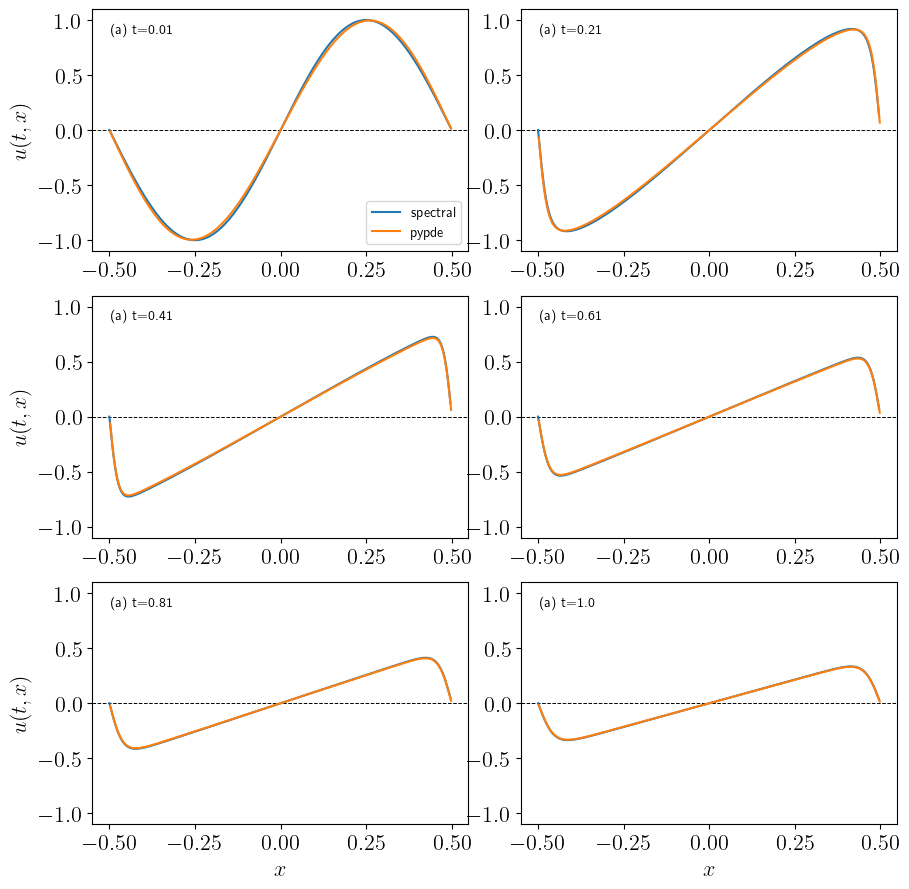

In [23]:
# initial profile of velocity field
fig, ax = plt.subplots(t_slice_list.shape[0], t_slice_list.shape[1], figsize=(9,9))

for i in range(t_slice_list.shape[0]):    
    for j in range(t_slice_list.shape[1]):

        t_slice = t_slice_list[i,j]
        
        spec_vals = np.real(np.fft.fftshift(vspace[t_slice,:]))
        # below, item() is used to convert np.int64 to native python integer
        # only native python integers can be used for indexing arrays
        pde_vals  = storage[t_slice.item()+1].data
        diff_vals = pde_vals - spec_vals

        ax[i,j].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
        ax[i,j].plot(X,spec_vals,label='spectral')
        ax[i,j].plot(XPDE,pde_vals,label='pypde')
        ax[i,j].text(0.05,0.9,f'(a) t={(t_slice+1)*Ttotal/NTsave}',transform=ax[i,j].transAxes)
        ax[i,j].set_ylim(-1.1,1.1)

# y label on the left corner
ax[0,0].set_ylabel("$u(t,x)$")
ax[1,0].set_ylabel("$u(t,x)$")
ax[2,0].set_ylabel("$u(t,x)$")
# x label on the bottom row
ax[2,0].set_xlabel("$x$")
ax[2,1].set_xlabel("$x$")

ax[0,0].legend(loc='lower right')

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

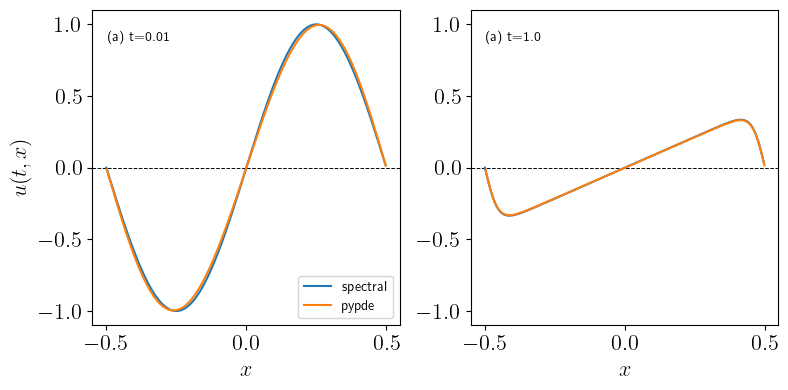

In [29]:
# initial profile of velocity field
fig, ax = plt.subplots(1, 2, figsize=(8,4))



t_slice = 0
i = 0

spec_vals = np.real(np.fft.fftshift(vspace[t_slice,:]))
# below, item() is used to convert np.int64 to native python integer
# only native python integers can be used for indexing arrays
pde_vals  = storage[t_slice+1].data
diff_vals = pde_vals - spec_vals

ax[i].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[i].plot(X,spec_vals,label='spectral')
ax[i].plot(XPDE,pde_vals,label='pypde')
ax[i].text(0.05,0.9,f'(a) t={(t_slice+1)*Ttotal/NTsave}',transform=ax[i].transAxes)
ax[i].set_ylim(-1.1,1.1)

t_slice = 99
i = 1

spec_vals = np.real(np.fft.fftshift(vspace[t_slice,:]))
# below, item() is used to convert np.int64 to native python integer
# only native python integers can be used for indexing arrays
pde_vals  = storage[t_slice+1].data
diff_vals = pde_vals - spec_vals

ax[i].axhline(y=0,linestyle='dashed',color='k',linewidth=0.7) # axis line
ax[i].plot(X,spec_vals,label='spectral')
ax[i].plot(XPDE,pde_vals,label='pypde')
ax[i].text(0.05,0.9,f'(a) t={(t_slice+1)*Ttotal/NTsave}',transform=ax[i].transAxes)
ax[i].set_ylim(-1.1,1.1)

# y label on the left corner
ax[0].set_ylabel("$u(t,x)$")
# x label on the bottom row
ax[0].set_xlabel("$x$")
ax[1].set_xlabel("$x$")

ax[0].legend(loc='lower right')

plt.tight_layout()
#plt.savefig(f'{path}/figs/bwn_velocity_profile_finite.png', dpi=200, facecolor='white', transparent=False)
plt.show()

In [ ]:
# inf norm difference between pypde and spectral code
# measured with respect to max intensity at the given time
# don't know why it has this shape, and we see some significant differences
# almost 10% error

max_diff = np.empty(NTsave)
for i,field in enumerate(storage):
    if i!=0:
        max_diff[i-1] = np.max(np.abs(field.data - np.real(np.fft.fftshift(vspace[i-1,:])))) / np.max(np.abs(field.data))

plt.plot( max_diff, color='k' )
plt.show()